# XGBoost

This notebook shows our process for selecting hyperparameters and features for the xgboost model

In [0]:
from pyspark.sql import types, Window, functions as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, StringIndexer
from sparkdl.xgboost import XgboostClassifier, XgboostClassifierModel
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics

# Good links

- [Data Clean](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324234161/command/1898361324234162)
- [Ester Feature Eng](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324251838/command/1898361324251866)
- [Weather var dictionary](https://docs.google.com/spreadsheets/d/1xthRtOjC5-kV0LMIRa_grkxZ6sLBlpqDpNwygOH_jlA/edit#gid=1829391731)

# Functions and global objects for data cleaning

In [0]:
%run ../Phase_3/dataclean_functions

In [0]:
# Metrics Functions
def evaluate_metrics(df):
    '''pass in dataframe with 2 columns: prediction, label
    '''
    
    result_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f0_5_score': [], 'f1_score': [], 'f2_score': []}
    
    df = df.select('prediction', 'label')
    
    metrics = MulticlassMetrics(df.rdd)
    
    # classification metrics
    cm = metrics.confusionMatrix().toArray()
    accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
    precision = (cm[1][1]) / (cm[1][1] + cm[0][1])
    recall = (cm[1][1]) / (cm[1][1] + cm[1][0])
    
    def f_score(beta, precision, recall):
        return (1+beta**2) * precision * recall / (beta**2 * precision + recall)
    
    # save all metrics
    result_metrics['accuracy'].append(accuracy)
    result_metrics['precision'].append(precision)
    result_metrics['recall'].append(recall)
    result_metrics['f0_5_score'].append(f_score(0.5, precision, recall))
    result_metrics['f1_score'].append(f_score(1, precision, recall))
    result_metrics['f2_score'].append(f_score(2, precision, recall))
    
    return result_metrics



# Function that saves all metrics from every cross validation run to a dictionary
# loop this across all grid search 
def evaluate_cross_folds(folds, model, features, y_var='DEP_DEL15_AIRLNS', verbose=True):
    '''
    Function to run through the proper cross validation with your single model and evaluate performance metrics on each fold
    
    Inputs:
    - folds: Use Yi's make_cv_folds(df) function and pass this object in
    - model: pass in a single model object to be evaluate
    - features: list of features to use as explanatory variables
    
    Output:
    - Dictionary of the main classification metrics for each k-fold CV
    '''
    
    all_metrics_train = {'accuracy': [], 'precision': [], 'recall': [], 'f0_5_score': [], 'f1_score': [], 'f2_score': []}
    all_metrics_dev = {'accuracy': [], 'precision': [], 'recall': [], 'f0_5_score': [], 'f1_score': [], 'f2_score': []}
    
    for i, fold_i in enumerate(folds):
        
        if verbose:
            print(f'Fitting model {i+1} of {len(folds)}')
        
        #train = undersample(fold_i[0])
        train = fold_i[0]
        dev = fold_i[1]
        
        # select fields we're using
        train = train.select(features + [y_var])
        dev = dev.select(features + [y_var])

        # put data into the pyspark form
        vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features', handleInvalid='skip')
        train = vectorAssembler.transform(train).select(['features', y_var])
        dev = vectorAssembler.transform(dev).select(['features', y_var])

        # cache data
        #train.cache()
        #dev.cache()
        
        # fit model
        model_fit = model.fit(train)
        
        # make preds
        train_pred = model_fit.transform(train)
        dev_pred = model_fit.transform(dev)
        dev_pred.cache()
        
        # calculate all metrics and append them to the dictionary
        results_train = evaluate_metrics(train_pred.withColumnRenamed(y_var, "label").select(['prediction', 'label']))
        results_dev = evaluate_metrics(dev_pred.withColumnRenamed(y_var, "label").select(['prediction', 'label']))
        
        for j in ['accuracy', 'precision', 'recall', 'f0_5_score', 'f1_score', 'f2_score']:
            all_metrics_train[j].append(results_train[j])
            all_metrics_dev[j].append(results_dev[j])
        
    return all_metrics_train, all_metrics_dev

# Read in Data

In [0]:
blob_container = "main-storage" # The name of your container created in https://portal.azure.com
storage_account = "team05w261" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team05" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team05-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# Configure blob storage account access key globally
spark.conf.set(
  f"fs.azure.account.key.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

df_numrows = df.count()
print(f"number of rows: {df_numrows}")
print(f"number of columns: {len(df.columns)}")
display(df)

number of rows: 31178801
number of columns: 362

YEAR_AIRLNS QUARTER_AIRLNS MONTH_AIRLNS DAY_OF_MONTH_AIRLNS DAY_OF_WEEK_AIRLNS FL_DATE_AIRLNS CRS_DEP_TIME_AIRLNS CRS_ARR_TIME_AIRLNS CRS_ELAPSED_TIME_AIRLNS ORIGIN_AIRLNS DEST_AIRLNS OP_UNIQUE_CARRIER_AIRLNS FLIGHTS_AIRLNS DISTANCE_AIRLNS DEP_DEL15_AIRLNS LATITUDE_WTHR_origin LONGITUDE_WTHR_origin ELEVATION_WTHR_origin LATITUDE_WTHR_dest LONGITUDE_WTHR_dest ELEVATION_WTHR_dest WND_WTHR_direction_angle_origin WND_WTHR_speed_rate_origin CIG_WTHR_ceiling_height_dimension_origin VIS_WTHR_distance_dimension_origin TMP_WTHR_air_temperature_origin DEW_WTHR_dew_point_temperature_origin SLP_WTHR_sea_level_pressure_origin GA1_WTHR_base_height_dimension_origin GF1_WTHR_lowest_cloud_base_height_dimension_origin MA1_WTHR_altimeter_setting_rate_origin MA1_WTHR_station_pressure_rate_origin AA1_WTHR_period_quantity_in_hours_origin AA1_WTHR_depth_dimension_origin AA2_WTHR_period_quantity_in_hours_origin AA2_WTHR_depth_dimension_origin AJ1_WTHR_dimension_origin AJ1_WTHR_equivalent_water_depth_dimension_origin AL1_WTHR_period_quantity_origin AL1_WTHR_depth_dimension_origin AN1_WTHR_period_quantity_origin AN1_WTHR_depth_dimension_origin AO1_WTHR_period_quantity_in_minutes_origin AO1_WTHR_depth_dimension_origin WND_WTHR_direction_angle_dest WND_WTHR_speed_rate_dest CIG_WTHR_ceiling_height_dimension_dest VIS_WTHR_distance_dimension_dest TMP_WTHR_air_temperature_dest DEW_WTHR_dew_point_temperature_dest SLP_WTHR_sea_level_pressure_dest GA1_WTHR_base_height_dimension_dest GF1_WTHR_lowest_cloud_base_height_dimension_dest MA1_WTHR_altimeter_setting_rate_dest MA1_WTHR_station_pressure_rate_dest AA1_WTHR_period_quantity_in_hours_dest AA1_WTHR_depth_dimension_dest AA2_WTHR_period_quantity_in_hours_dest AA2_WTHR_depth_dimension_dest AJ1_WTHR_dimension_dest AJ1_WTHR_equivalent_water_depth_dimension_dest AL1_WTHR_period_quantity_dest AL1_WTHR_depth_dimension_dest AN1_WTHR_period_quantity_dest AN1_WTHR_depth_dimension_dest AO1_WTHR_period_quantity_in_minutes_dest AO1_WTHR_depth_dimension_dest WND_WTHR_type_code_origin-V WND_WTHR_type_code_origin-C WND_WTHR_type_code_origin-N WND_WTHR_type_code_origin-R WND_WTHR_type_code_origin-H CIG_WTHR_ceiling_determination_code_origin-M CIG_WTHR_ceiling_determination_code_origin-C CIG_WTHR_ceiling_determination_code_origin-W CIG_WTHR_CAVOK_code_origin-Y CIG_WTHR_CAVOK_code_origin-N GA1_WTHR_coverage_code_origin-00 GA1_WTHR_coverage_code_origin-01 GA1_WTHR_coverage_code_origin-02 GA1_WTHR_coverage_code_origin-03 GA1_WTHR_coverage_code_origin-04 GA1_WTHR_coverage_code_origin-05 GA1_WTHR_coverage_code_origin-06 GA1_WTHR_coverage_code_origin-07 GA1_WTHR_coverage_code_origin-08 GA1_WTHR_coverage_code_origin-09 GA1_WTHR_coverage_code_origin-10 GA1_WTHR_cloud_type_code_origin-00 GA1_WTHR_cloud_type_code_origin-01 GA1_WTHR_cloud_type_code_origin-02 GA1_WTHR_cloud_type_code_origin-03 GA1_WTHR_cloud_type_code_origin-04 GA1_WTHR_cloud_type_code_origin-05 GA1_WTHR_cloud_type_code_origin-06 GA1_WTHR_cloud_type_code_origin-07 GA1_WTHR_cloud_type_code_origin-08 GA1_WTHR_cloud_type_code_origin-09 GA1_WTHR_cloud_type_code_origin-10 GA1_WTHR_cloud_type_code_origin-12 GA1_WTHR_cloud_type_code_origin-15 GF1_WTHR_total_coverage_code_origin-00 GF1_WTHR_total_coverage_code_origin-01 GF1_WTHR_total_coverage_code_origin-02 GF1_WTHR_total_coverage_code_origin-03 GF1_WTHR_total_coverage_code_origin-04 GF1_WTHR_total_coverage_code_origin-05 GF1_WTHR_total_coverage_code_origin-06 GF1_WTHR_total_coverage_code_origin-07 GF1_WTHR_total_coverage_code_origin-08 GF1_WTHR_total_coverage_code_origin-09 GF1_WTHR_total_lowest_cloud_cover_code_origin-00 GF1_WTHR_total_lowest_cloud_cover_code_origin-01 GF1_WTHR_total_lowest_cloud_cover_code_origin-02 GF1_WTHR_total_lowest_cloud_cover_code_origin-03 GF1_WTHR_total_lowest_cloud_cover_code_origin-04 GF1_WTHR_total_lowest_cloud_cover_code_origin-05 GF1_WTHR_total_lowest_cloud_cover_code_origin-06 GF1_WTHR_total_lowest_cloud_cover_code_origin-07 GF1_WTHR_total_lowest_cloud_cover_code_origin-08 GF1_WTHR_total_lowest_c

# Data Clean

In [0]:
def clean_data_for_tree_model(df):

    # cast to int
    str_cols = ['Prev_Flight_Delay_15', 'Poor_Schedule', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep']
    for column in str_cols:
        df = df.withColumn(column, F.col(column).cast(types.IntegerType())) 
    
    # drop missing values from Y var
    df = df.filter(~F.col('DEP_DEL15_AIRLNS').isNull())

    # impute some missing values
    df = df.na.fill(0)
    
    # get fields
    features = [i for i in df.columns if i != "DEP_DEL15_AIRLNS"]
    str_cols = [t[0] for t in df.dtypes if t[1] == 'string' and t[0] in features]
    # drop some features
    #features.remove('FL_DATE_AIRLNS')
    
    # index all str columns    
    vars_to_index = [i for i in str_cols if i != 'FL_DATE_AIRLNS']

    # rename cols to drop them later
    for var in vars_to_index:
        df = df.withColumnRenamed(var, var+'_old')

    # finally, index them
    indexer = StringIndexer(inputCols=[i+'_old' for i in vars_to_index], outputCols=vars_to_index)
    df = indexer.fit(df).transform(df)
    df = df.drop(*[i+'_old' for i in vars_to_index])
    
    return df

In [0]:
def clean_data_for_tree_model2(df):

    # cast to int
    str_cols = ['Prev_Flight_Delay_15', 'Poor_Schedule', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep']
    for column in str_cols:
        df = df.withColumn(column, F.col(column).cast(types.IntegerType())) 
    
    # drop missing values from Y var
    df = df.filter(~F.col('DEP_DEL15_AIRLNS').isNull())

    # impute some missing values
    df = df.na.fill(0)
    
    # get fields
    features = [i for i in df.columns if i != "DEP_DEL15_AIRLNS"]
    str_cols = [t[0] for t in df.dtypes if t[1] == 'string' and t[0] in features]
    # drop some features
    features.remove('FL_DATE_AIRLNS')
    
    # index all str columns    
    vars_to_index = str_cols

    # rename cols to drop them later
    for var in vars_to_index:
        df = df.withColumnRenamed(var, var+'_old')

    # finally, index them
    indexer = StringIndexer(inputCols=[i+'_old' for i in vars_to_index], outputCols=vars_to_index)
    df = indexer.fit(df).transform(df)
    df = df.drop(*[i+'_old' for i in vars_to_index])
    
    return df

# Modeling

In [0]:
# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 
  #'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 'AA2_WTHR_depth_dimension_origin', 
    'AJ1_WTHR_equivalent_water_depth_dimension_origin', 'AN1_WTHR_depth_dimension_origin', 
    'AL1_WTHR_period_quantity_origin', 'AL1_WTHR_depth_dimension_origin',
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 'AA2_WTHR_depth_dimension_dest', 
    'AJ1_WTHR_equivalent_water_depth_dimension_dest', 'AN1_WTHR_depth_dimension_dest', 
    'AL1_WTHR_period_quantity_dest', 'AL1_WTHR_depth_dimension_dest',
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'


df = df.select(X_vars + [y_var])
display(df)

YEAR_AIRLNS QUARTER_AIRLNS MONTH_AIRLNS DAY_OF_WEEK_AIRLNS CRS_ELAPSED_TIME_AIRLNS DISTANCE_AIRLNS ELEVATION_WTHR_origin ELEVATION_WTHR_dest LATITUDE_WTHR_origin LONGITUDE_WTHR_origin LATITUDE_WTHR_dest LONGITUDE_WTHR_dest ORIGIN_AIRLNS DEST_AIRLNS OP_UNIQUE_CARRIER_AIRLNS WND_WTHR_direction_angle_origin WND_WTHR_speed_rate_origin TMP_WTHR_air_temperature_origin DEW_WTHR_dew_point_temperature_origin VIS_WTHR_distance_dimension_origin GA1_WTHR_base_height_dimension_origin GF1_WTHR_lowest_cloud_base_height_dimension_origin AA1_WTHR_period_quantity_in_hours_origin AA1_WTHR_depth_dimension_origin AA2_WTHR_depth_dimension_origin AJ1_WTHR_equivalent_water_depth_dimension_origin AN1_WTHR_depth_dimension_origin AL1_WTHR_period_quantity_origin AL1_WTHR_depth_dimension_origin WND_WTHR_direction_angle_dest WND_WTHR_speed_rate_dest TMP_WTHR_air_temperature_dest DEW_WTHR_dew_point_temperature_dest VIS_WTHR_distance_dimension_dest GA1_WTHR_base_height_dimension_dest GF1_WTHR_lowest_cloud_base_height_dimension_dest AA1_WTHR_period_quantity_in_hours_dest AA1_WTHR_depth_dimension_dest AA2_WTHR_depth_dimension_dest AJ1_WTHR_equivalent_water_depth_dimension_dest AN1_WTHR_depth_dimension_dest AL1_WTHR_period_quantity_dest AL1_WTHR_depth_dimension_dest LOCAL_DEP_HOUR HOLIDAY Prev_Flight_Delay_15 Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep Poor_Schedule DEP_DEL15_AIRLNS 2015 1 1 4 168.0 992.0 3.4 3.0 26.07875 -80.16217 39.87327 -75.22678 FLL PHL US 90.0 3.6 24.4 20.6 16093.0 762.0 762.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 250.0 11.3 4.4 -11.1 16093.0 7620.0 7620.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 14 1 0 1 0 0.0 2015 1 1 4 167.0 920.0 3.0 5.8 39.87327 -75.22678 27.96194 -82.5403 PHL TPA US 220.0 8.2 5.6 -10.0 16093.0 7620.0 7620.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 2.6 22.2 16.7 16093.0 640.0 640.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 17 1 0 1 0 1.0 2015 1 1 5 100.0 507.0 5.8 221.9 27.96194 -82.5403 35.2236 -80.9552 TPA CLT US 50.0 2.1 17.2 16.7 805.0 61.0 61.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 7.2 0.0 16093.0 3353.0 3353.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 6 2 1 1 0 0.0 2015 1 1 6 107.0 541.0 221.9 3.4 35.2236 -80.9552 40.6386 -73.7622 CLT JFK US 60.0 1.5 8.9 7.2 12000.0 450.0 450.0 3.0 3.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 -6.7 16000.0 0.0 6000.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7 2 0 1 0 0.0 2015 1 1 6 120.0 541.0 3.4 221.9 40.6386 -73.7622 35.2236 -80.9552 JFK CLT US 50.0 3.6 -0.6 -6.1 16000.0 0.0 6000.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 60.0 2.1 8.9 7.2 12000.0 250.0 250.0 6.0 3.0 6.1 0.0 0.0 0.0 0.0 10 2 0 1 0 0.0 2015 1 1 6 212.0 1475.0 221.9 2.7 35.2236 -80.9552 18.4325 -66.01083 CLT SJU US 40.0 2.1 9.4 7.2 4000.0 150.0 150.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 60.0 9.8 28.3 21.1 16093.0 884.0 884.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 13 2 0 1 0 1.0 2015 1 1 6 222.0 1475.0 2.7 221.9 18.4325 -66.01083 35.2236 -80.9552 SJU CLT US 60.0 7.7 27.2 23.3 16093.0 732.0 732.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 10.0 2.1 11.0 9.0 1609.0 152.0 152.0 1.0 0.2 0.0 0.0 0.0 0.0 0.0 18 2 1 0 0 1.0 2015 1 1 6 162.0 930.0 221.9 265.8 35.2236 -80.9552 44.8831 -93.2289 CLT MSP US 360.0 1.5 10.0 8.9 1600.0 75.0 75.0 6.0 3.0 0.0 0.0 0.0 0.0 0.0 350.0 6.7 -2.2 -6.7 11000.0 800.0 800.0 0.0 0.0 0.0 80.0 0.0 0.0 0.0 22 2 1 0 0 1.0 2015 1 1 7 157.0 930.0 265.8 221.9 44.8831 -93.2289 35.2236 -80.9552 MSP CLT US 330.0 7.2 -15.6 -20.0 16093.0 0.0 6000.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 320.0 3.1 8.9 7.8 805.0 61.0 61.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 5 2 1 1 0 0.0 2015 1 1 7 87.0 361.0 221.9 47.5 35.2236 -80.9552 39.1733 -76.684 CLT BWI US 90.0 1.5 8.9 8.3 402.0 61.0 61.0 1.0 0.0 0.3 0.0 0.0 0.0 0.0 230.0 1.5 6.7 6.1 9656.0 183.0 183.0 1.0 0.5 3.6 0.0 0.0 0.0 0.0 9 2 0 1 0 0.0 2015 1 1 7 87.0 361.0 47.5 221.9 39.1733 -76.684 35.2236 -80.9552 BWI CLT US 190.0 3.1 9.0 8.0 16093.0 183.0 183.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 10.0 9.0 402.0 274.0 274.0 1.0 4.3 0.0 0.0 0.0 0.0 0.0 12 2 0 1 0 0.0 2015 1 1 7 106.0 541.0 221.9 3.4 35.2236 -80.9552 40.6386 -73.7622 CLT JFK US 170.0 3.6 13.0 12.0 11265.0 61.0 61.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 210.0

In [0]:
# optional. check for nulls
# for var in df.columns:
#     num_nulls = df.select(f'{var}').filter(f'{var} is null').count()
#     num_nans = df.filter(F.isnan(f'{var}')).count()
#     print(f'nulls: {num_nulls}, nans: {num_nans} in {var}')

# GBT

Use a GBT model just for extracting feature importances

In [0]:
spark.catalog.clearCache()

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018).sample(.1, seed=1)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# undersample train
df_train = undersample(df_train)

# select fields we're using
df_train = df_train.select(X_vars + [y_var])
df_test = df_test.select(X_vars + [y_var])

# put data into the pyspark form
vectorAssembler = VectorAssembler(inputCols = X_vars, outputCol = 'features', handleInvalid='skip')
df_train = vectorAssembler.transform(df_train).select(['features', y_var])
df_test = vectorAssembler.transform(df_test).select(['features', y_var])

# cache data
df_train.cache()
df_test.cache()
print(f'train row count {df_train.count()}')
print(f'test row count {df_test.count()}')

# fit model
gbt_fit = GBTClassifier(featuresCol='features', labelCol=y_var, seed=1
                       ,featureSubsetStrategy='sqrt'
                       ,subsamplingRate=.8
                       ,maxBins=370
                       ,stepSize=.1
                       ,maxIter=50 # increase later to 100
                       ,maxDepth=12 # maybe make 15 later
                      )
gbt_fit = gbt_fit.fit(df_train)

# make preds
df_train = gbt_fit.transform(df_train)
df_test = gbt_fit.transform(df_test)
df_train.cache()
df_test.cache()
print(df_train.count())
print(df_test.count())

tr_metrics = evaluate_metrics(df_train.withColumnRenamed("dep_del15_airlns", "label").select(['prediction', 'label']))
te_metrics = evaluate_metrics(df_test.withColumnRenamed("dep_del15_airlns", "label").select(['prediction', 'label']))
print(tr_metrics)
print(te_metrics)

train row count 862278
test row count 7268232
862278
7268232
{'accuracy': [0.8077638534208225], 'precision': [0.7719681374007885], 'recall': [0.8731127082288707], 'f0_5_score': [0.7902778734970441], 'f1_score': [0.8194310849864868], 'f2_score': [0.8508175961772069]}
{'accuracy': [0.7576651378216875], 'precision': [0.90834987178562], 'recall': [0.7810147574556116], 'f0_5_score': [0.8796660657536113], 'f1_score': [0.8398834005612161], 'f2_score': [0.8035433644062916]}

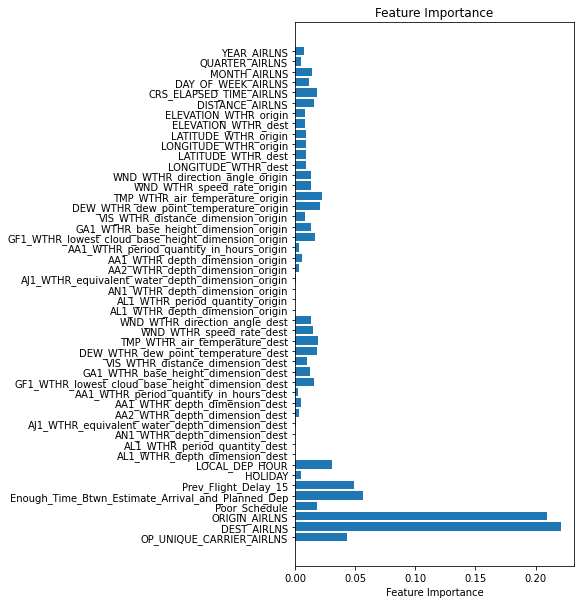

In [0]:
# varimp plot

list_extract = []
for i in df_train.schema['features'].metadata["ml_attr"]["attrs"]:
    list_extract = list_extract + df_train.schema['features'].metadata["ml_attr"]["attrs"][i]
varlist = pd.DataFrame(list_extract)
varlist['score'] = varlist['idx'].apply(lambda x: gbt_fit.featureImportances[x])
varlist.sort_values('score', ascending = False)

fig, ax = plt.subplots(figsize=(5, 10))
x = np.arange(len(varlist.name))
ax.barh(x, varlist.score)
ax.set_yticks(np.arange(len(varlist.name)))
ax.set_yticklabels(varlist.name)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importance')
print("")

# XGBoost

Perform a grid search to hyperparameter tune

In [0]:
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 
  #'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'

# i think we need FL_DATE_AIRLNS for the make_cv_folds function
df = df.select(X_vars + [y_var] + ['FL_DATE_AIRLNS'])
df = clean_data_for_tree_model(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# use a small piece of the data to speed things up
# remember to run undersample(df_train) when we're not doing CV. This is baked into the evaluate_cross_folds func
df_train = df_train.sample(.1, seed=1) 
df_train.cache()
print(f'df_train count: {df_train.count()}')


# evaluate through 5-fold cv
folds = make_cv_folds(df_train)

# collect results like this
cv_results_all = {}
cv_results_all['max_depth'] = []
cv_results_all['n_estimators'] = []
cv_results_all['learning_rate'] = []
cv_results_all['gamma'] = []
cv_results_all['train_f1_score'] = []
cv_results_all['test_f1_score'] = []
cv_results_all['train_f2_score'] = []
cv_results_all['test_f2_score'] = []


# this tests out 2^4 = 16 configurations
for max_depth_ in [7, 10]:
    for n_estimators_ in [30, 50]:
        for learning_rate_ in [.07, .1]:
            for gamma_ in [0, .05]:
                xgb = XgboostClassifier(labelCol=y_var, missing=0.0
                                        ,max_depth=max_depth_
                                        ,n_estimators=n_estimators_
                                        ,learning_rate=learning_rate_
                                        ,colsample_bytree=.8 
                                        ,gamma=gamma_
                                        ,reg_alpha=0 
                                        ,reg_lambda=0 
                                        ,min_child_weight=0)
                xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')
                cv_results_all['max_depth'].append(max_depth_)
                cv_results_all['n_estimators'].append(n_estimators_)
                cv_results_all['learning_rate'].append(learning_rate_)
                cv_results_all['gamma'].append(gamma_)
                cv_results_all['train_f1_score'].append(np.mean(xgb_results[0]['f1_score']))
                cv_results_all['test_f1_score'].append(np.mean(xgb_results[1]['f1_score']))
                cv_results_all['train_f2_score'].append(np.mean(xgb_results[0]['f2_score']))
                cv_results_all['test_f2_score'].append(np.mean(xgb_results[1]['f2_score']))

#
cv_results_df = pd.DataFrame(cv_results_all)
cv_results_df

df_train count: 2390740
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Out[45]:

max_depth 
 n_estimators 
 learning_rate 
 gamma 
 train_f1_score 
 test_f1_score 
 train_f2_score 
 test_f2_score 
 
 
 
 
 0 
 7 
 30 
 0.07 
 0.00 
 0.690122 
 0.515356 
 0.641841 
 0.562663 
 
 
 1 
 7 
 30 
 0.07 
 0.05 
 0.690122 
 0.515356 
 0.641841 
 0.562663 
 
 
 2 
 7 
 30 
 0.10 
 0.00 
 0.695038 
 0.516660 
 0.648330 
 0.566643 
 
 
 3 
 7 
 30 
 0.10 
 0.05 
 0.695039 
 0.516660 
 0.648331 
 0.566643 
 
 
 4 
 7 
 50 
 0.07 
 0.00 
 0.696743 
 0.518686 
 0.649263 
 0.567945 
 
 
 5 
 7 
 50 
 0.07 
 0.05 
 0.696739 
 0.518680 
 0.649259 
 0.567935 
 
 
 6 
 7 
 50 
 0.10 
 0.00 
 0.704461 
 0.518527 
 0.660563 
 0.573717 
 
 
 7 
 7 
 50 
 0.10 
 0.05 
 0.704474 
 0.518400 
 0.660565 
 0.573516 
 
 
 8 
 10 
 30 
 0.07 
 0.00 
 0.716951 
 0.519040 
 0.671664 
 0.573406 
 
 
 9 
 10 
 30 
 0.07 
 0.05 
 0.716828 
 0.519689 
 0.671528 
 0.573822 
 
 
 10 
 10 
 30 
 0.10 
 0.00 
 0.723936 
 0.519136 
 0.679548 
 0.575902 
 
 
 11 
 10 
 30 
 0.10 
 0.05 
 0.724196 
 0.519660 
 0.679902 
 0.575580 
 
 
 12 
 10 
 50 
 0.07 
 0.00 
 0.727645 
 0.521690 
 0.682844 
 0.577559 
 
 
 13 
 10 
 50 
 0.07 
 0.05 
 0.727692 
 0.521431 
 0.682871 
 0.576728 
 
 
 14 
 10 
 50 
 0.10 
 0.00 
 0.736888 
 0.519669 
 0.693928 
 0.579193 
 
 
 15 
 10 
 50 
 0.10 
 0.05 
 0.737031 
 0.519673 
 0.694170 
 0.579027

In [0]:
cv_results_df.sort_values('test_f2_score', ascending=False)

Out[48]:

max_depth 
 n_estimators 
 learning_rate 
 gamma 
 train_f1_score 
 test_f1_score 
 train_f2_score 
 test_f2_score 
 
 
 
 
 14 
 10 
 50 
 0.10 
 0.00 
 0.736888 
 0.519669 
 0.693928 
 0.579193 
 
 
 15 
 10 
 50 
 0.10 
 0.05 
 0.737031 
 0.519673 
 0.694170 
 0.579027 
 
 
 12 
 10 
 50 
 0.07 
 0.00 
 0.727645 
 0.521690 
 0.682844 
 0.577559 
 
 
 13 
 10 
 50 
 0.07 
 0.05 
 0.727692 
 0.521431 
 0.682871 
 0.576728 
 
 
 10 
 10 
 30 
 0.10 
 0.00 
 0.723936 
 0.519136 
 0.679548 
 0.575902 
 
 
 11 
 10 
 30 
 0.10 
 0.05 
 0.724196 
 0.519660 
 0.679902 
 0.575580 
 
 
 9 
 10 
 30 
 0.07 
 0.05 
 0.716828 
 0.519689 
 0.671528 
 0.573822 
 
 
 6 
 7 
 50 
 0.10 
 0.00 
 0.704461 
 0.518527 
 0.660563 
 0.573717 
 
 
 7 
 7 
 50 
 0.10 
 0.05 
 0.704474 
 0.518400 
 0.660565 
 0.573516 
 
 
 8 
 10 
 30 
 0.07 
 0.00 
 0.716951 
 0.519040 
 0.671664 
 0.573406 
 
 
 4 
 7 
 50 
 0.07 
 0.00 
 0.696743 
 0.518686 
 0.649263 
 0.567945 
 
 
 5 
 7 
 50 
 0.07 
 0.05 
 0.696739 
 0.518680 
 0.649259 
 0.567935 
 
 
 2 
 7 
 30 
 0.10 
 0.00 
 0.695038 
 0.516660 
 0.648330 
 0.566643 
 
 
 3 
 7 
 30 
 0.10 
 0.05 
 0.695039 
 0.516660 
 0.648331 
 0.566643 
 
 
 0 
 7 
 30 
 0.07 
 0.00 
 0.690122 
 0.515356 
 0.641841 
 0.562663 
 
 
 1 
 7 
 30 
 0.07 
 0.05 
 0.690122 
 0.515356 
 0.641841 
 0.562663

Top results here

```
max_depth	n_estimators	learning_rate	gamma	train_f1_score	test_f1_score	train_f2_score	test_f2_score
14	10	50	0.10	0.00	0.736888	0.519669	0.693928	0.579193
15	10	50	0.10	0.05	0.737031	0.519673	0.694170	0.579027
12	10	50	0.07	0.00	0.727645	0.521690	0.682844	0.577559
13	10	50	0.07	0.05	0.727692	0.521431	0.682871	0.576728
10	10	30	0.10	0.00	0.723936	0.519136	0.679548	0.57590
```

## Hyperparam tune round 2

Trying to add more vars and more hyperparam configs

In [0]:
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 
  #'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 'AA2_WTHR_depth_dimension_origin', 
    'AJ1_WTHR_equivalent_water_depth_dimension_origin', 'AN1_WTHR_depth_dimension_origin', 
    'AL1_WTHR_period_quantity_origin', 'AL1_WTHR_depth_dimension_origin',
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 'AA2_WTHR_depth_dimension_dest', 
    'AJ1_WTHR_equivalent_water_depth_dimension_dest', 'AN1_WTHR_depth_dimension_dest', 
    'AL1_WTHR_period_quantity_dest', 'AL1_WTHR_depth_dimension_dest',
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'

# i think we need FL_DATE_AIRLNS for the make_cv_folds function
df = df.select(X_vars + [y_var] + ['FL_DATE_AIRLNS'])
df = clean_data_for_tree_model(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# use a small piece of the data to speed things up
# remember to run undersample(df_train) when we're not doing CV. This is baked into the evaluate_cross_folds func
df_train = df_train.sample(.2, seed=1) 
df_train.cache()
print(f'df_train count: {df_train.count()}')


# evaluate through 5-fold cv
folds = make_cv_folds(df_train)

# collect results like this
cv_results_all = {}
cv_results_all['max_depth'] = []
cv_results_all['n_estimators'] = []
cv_results_all['learning_rate'] = []
cv_results_all['gamma'] = []
cv_results_all['lambda'] = []
cv_results_all['train_f1_score'] = []
cv_results_all['test_f1_score'] = []
cv_results_all['train_f2_score'] = []
cv_results_all['test_f2_score'] = []


# this tests out 3*2 = 6 configurations
for max_depth_ in [10, 12, 15]:
    for n_estimators_ in [50]:
        for learning_rate_ in [1]:
            for gamma_ in [.05]:
                for lambda_ in [0, .1]:
                    xgb = XgboostClassifier(labelCol=y_var, missing=0.0
                                            ,max_depth=max_depth_
                                            ,n_estimators=n_estimators_
                                            ,learning_rate=learning_rate_
                                            ,colsample_bytree=.8 
                                            ,gamma=gamma_
                                            ,reg_alpha=0 
                                            ,reg_lambda=lambda_
                                            ,min_child_weight=0)
                    
                    xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')
                    cv_results_all['max_depth'].append(max_depth_)
                    cv_results_all['n_estimators'].append(n_estimators_)
                    cv_results_all['learning_rate'].append(learning_rate_)
                    cv_results_all['gamma'].append(gamma_)
                    cv_results_all['lambda'].append(lambda_)
                    cv_results_all['train_f1_score'].append(np.mean(xgb_results[0]['f1_score']))
                    cv_results_all['test_f1_score'].append(np.mean(xgb_results[1]['f1_score']))
                    cv_results_all['train_f2_score'].append(np.mean(xgb_results[0]['f2_score']))
                    cv_results_all['test_f2_score'].append(np.mean(xgb_results[1]['f2_score']))

#
cv_results_df = pd.DataFrame(cv_results_all)
cv_results_df.sort_values('test_f2_score', ascending=False)

df_train count: 4779566
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
''Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Out[50]:

max_depth 
 n_estimators 
 learning_rate 
 gamma 
 lambda 
 train_f1_score 
 test_f1_score 
 train_f2_score 
 test_f2_score 
 
 
 
 
 1 
 10 
 50 
 1 
 0.05 
 0.1 
 0.782554 
 0.462352 
 0.757207 
 0.557634 
 
 
 0 
 10 
 50 
 1 
 0.05 
 0.0 
 0.772749 
 0.458878 
 0.746139 
 0.556060 
 
 
 2 
 12 
 50 
 1 
 0.05 
 0.0 
 0.812619 
 0.433857 
 0.793844 
 0.541248 
 
 
 3 
 12 
 50 
 1 
 0.05 
 0.1 
 0.802854 
 0.431489 
 0.787216 
 0.539898 
 
 
 5 
 15 
 50 
 1 
 0.05 
 0.1 
 0.891106 
 0.419573 
 0.890728 
 0.534912 
 
 
 4 
 15 
 50 
 1 
 0.05 
 0.0 
 0.785288 
 0.409664 
 0.786569 
 0.526348

results hard coded

```
max_depth	n_estimators	learning_rate	gamma	lambda	train_f1_score	test_f1_score	train_f2_score	test_f2_score
1	10	50	1	0.05	0.1	0.782554	0.462352	0.757207	0.557634
0	10	50	1	0.05	0.0	0.772749	0.458878	0.746139	0.556060
2	12	50	1	0.05	0.0	0.812619	0.433857	0.793844	0.541248
3	12	50	1	0.05	0.1	0.802854	0.431489	0.787216	0.539898
5	15	50	1	0.05	0.1	0.891106	0.419573	0.890728	0.534912
4	15	50	1	0.05	0.0	0.785288	0.409664	0.786569	0.526348
```

# Tune again

This time Include all the features and see how it performs

In [0]:
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

features = [i for i in df.columns if i != "DEP_DEL15_AIRLNS"]
str_cols = [t[0] for t in df.dtypes if t[1] == 'string' and t[0] in features]
features.remove('FL_DATE_AIRLNS')

# select explanatory vars
X_vars = features
y_var = 'DEP_DEL15_AIRLNS'

# i think we need FL_DATE_AIRLNS for the make_cv_folds function
df = df.select(X_vars + [y_var] + ['FL_DATE_AIRLNS'])
df = clean_data_for_tree_model2(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# use a small piece of the data to speed things up
# remember to run undersample(df_train) when we're not doing CV. This is baked into the evaluate_cross_folds func
df_train = df_train.sample(.2, seed=1) 
df_train.cache()
print(f'df_train count: {df_train.count()}')


# evaluate through 5-fold cv
folds = make_cv_folds(df_train)

# collect results like this
cv_results_all = {}
cv_results_all['max_depth'] = []
cv_results_all['n_estimators'] = []
cv_results_all['learning_rate'] = []
cv_results_all['gamma'] = []
cv_results_all['lambda'] = []
cv_results_all['train_f1_score'] = []
cv_results_all['test_f1_score'] = []
cv_results_all['train_f2_score'] = []
cv_results_all['test_f2_score'] = []


# this tests out 3*2 = 6 configurations
for max_depth_ in [10, 12, 15]:
    for n_estimators_ in [50]:
        for learning_rate_ in [1]:
            for gamma_ in [.05]:
                for lambda_ in [0, .1]:
                    xgb = XgboostClassifier(labelCol=y_var, missing=0.0
                                            ,max_depth=max_depth_
                                            ,n_estimators=n_estimators_
                                            ,learning_rate=learning_rate_
                                            ,colsample_bytree=.8 
                                            ,gamma=gamma_
                                            ,reg_alpha=0 
                                            ,reg_lambda=lambda_
                                            ,min_child_weight=0)
                    
                    xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')
                    cv_results_all['max_depth'].append(max_depth_)
                    cv_results_all['n_estimators'].append(n_estimators_)
                    cv_results_all['learning_rate'].append(learning_rate_)
                    cv_results_all['gamma'].append(gamma_)
                    cv_results_all['lambda'].append(lambda_)
                    cv_results_all['train_f1_score'].append(np.mean(xgb_results[0]['f1_score']))
                    cv_results_all['test_f1_score'].append(np.mean(xgb_results[1]['f1_score']))
                    cv_results_all['train_f2_score'].append(np.mean(xgb_results[0]['f2_score']))
                    cv_results_all['test_f2_score'].append(np.mean(xgb_results[1]['f2_score']))

#
cv_results_df = pd.DataFrame(cv_results_all)
cv_results_df.sort_values('test_f2_score', ascending=False)

# Tune again

In [0]:
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 'AA2_WTHR_depth_dimension_origin', 
    'AJ1_WTHR_equivalent_water_depth_dimension_origin', 'AN1_WTHR_depth_dimension_origin', 
    'AL1_WTHR_period_quantity_origin', 'AL1_WTHR_depth_dimension_origin', 'SLP_WTHR_sea_level_pressure_origin',
    'GA1_WTHR_coverage_code_origin-00', 'GF1_WTHR_total_coverage_code_origin-00', 'AA1_WTHR_condition_code_origin-3', 'AU1_WTHR_descriptor_code_origin-0',
    'AU1_WTHR_descriptor_code_origin-7', 'AU1_WTHR_obscuration_code_origin-0', 'AU1_WTHR_other_weather_phenomena_code_origin-0', 

    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 'AA2_WTHR_depth_dimension_dest', 
    'AJ1_WTHR_equivalent_water_depth_dimension_dest', 'AN1_WTHR_depth_dimension_dest', 
    'AL1_WTHR_period_quantity_dest', 'AL1_WTHR_depth_dimension_dest', 'SLP_WTHR_sea_level_pressure_dest', 
    'GA1_WTHR_coverage_code_dest-00', 'GF1_WTHR_total_coverage_code_dest-00', 'AA1_WTHR_condition_code_dest-3', 'AA1_WTHR_condition_code_dest-3',
    'AU1_WTHR_descriptor_code_dest-7', 'AU1_WTHR_obscuration_code_dest-0', 'AU1_WTHR_other_weather_phenomena_code_dest-0', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

X_vars = list(set(X_vars))
y_var = 'DEP_DEL15_AIRLNS'

# i think we need FL_DATE_AIRLNS for the make_cv_folds function
df = df.select(X_vars + [y_var] + ['FL_DATE_AIRLNS'])
df = clean_data_for_tree_model2(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# use a small piece of the data to speed things up
# remember to run undersample(df_train) when we're not doing CV. This is baked into the evaluate_cross_folds func
df_train = df_train.sample(.2, seed=1) 
df_train.cache()
print(f'df_train count: {df_train.count()}')


# evaluate through 5-fold cv
folds = make_cv_folds(df_train)
display(folds[0][0])

df_train count: 4780450

AA1_WTHR_condition_code_dest-3 GF1_WTHR_total_coverage_code_dest-00 ELEVATION_WTHR_dest ELEVATION_WTHR_origin AU1_WTHR_descriptor_code_dest-7 TMP_WTHR_air_temperature_origin AU1_WTHR_descriptor_code_origin-7 VIS_WTHR_distance_dimension_dest GA1_WTHR_coverage_code_origin-00 AN1_WTHR_depth_dimension_dest AA1_WTHR_condition_code_origin-3 DEW_WTHR_dew_point_temperature_dest AA2_WTHR_depth_dimension_dest LONGITUDE_WTHR_origin AA2_WTHR_depth_dimension_origin QUARTER_AIRLNS AU1_WTHR_obscuration_code_origin-0 AL1_WTHR_depth_dimension_dest Prev_Flight_Delay_15 AU1_WTHR_descriptor_code_origin-0 Poor_Schedule CRS_ARR_TIME_AIRLNS AU1_WTHR_other_weather_phenomena_code_origin-0 SLP_WTHR_sea_level_pressure_origin WND_WTHR_speed_rate_origin CRS_ELAPSED_TIME_AIRLNS AL1_WTHR_depth_dimension_origin VIS_WTHR_distance_dimension_origin LATITUDE_WTHR_origin GF1_WTHR_lowest_cloud_base_height_dimension_origin WND_WTHR_direction_angle_origin AA1_WTHR_period_quantity_in_hours_origin DISTANCE_AIRLNS SLP_WTHR_sea_level_pressure_dest Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep GA1_WTHR_base_height_dimension_dest AJ1_WTHR_equivalent_water_depth_dimension_dest TMP_WTHR_air_temperature_dest AL1_WTHR_period_quantity_origin WND_WTHR_direction_angle_dest AA1_WTHR_depth_dimension_origin GA1_WTHR_coverage_code_dest-00 CRS_DEP_TIME_AIRLNS DEW_WTHR_dew_point_temperature_origin AU1_WTHR_obscuration_code_dest-0 YEAR_AIRLNS GA1_WTHR_base_height_dimension_origin AA1_WTHR_depth_dimension_dest AA1_WTHR_period_quantity_in_hours_dest AN1_WTHR_depth_dimension_origin GF1_WTHR_lowest_cloud_base_height_dimension_dest GF1_WTHR_total_coverage_code_origin-00 HOLIDAY DAY_OF_WEEK_AIRLNS AJ1_WTHR_equivalent_water_depth_dimension_origin WND_WTHR_speed_rate_dest MONTH_AIRLNS LATITUDE_WTHR_dest AU1_WTHR_other_weather_phenomena_code_dest-0 LOCAL_DEP_HOUR LONGITUDE_WTHR_dest AL1_WTHR_period_quantity_dest DEP_DEL15_AIRLNS ORIGIN_AIRLNS DEST_AIRLNS OP_UNIQUE_CARRIER_AIRLNS FL_DATE_AIRLNS

In [0]:
display(df_train)

AA1_WTHR_condition_code_dest-3 GF1_WTHR_total_coverage_code_dest-00 ELEVATION_WTHR_dest ELEVATION_WTHR_origin AU1_WTHR_descriptor_code_dest-7 TMP_WTHR_air_temperature_origin AU1_WTHR_descriptor_code_origin-7 VIS_WTHR_distance_dimension_dest GA1_WTHR_coverage_code_origin-00 AN1_WTHR_depth_dimension_dest AA1_WTHR_condition_code_origin-3 DEW_WTHR_dew_point_temperature_dest AA2_WTHR_depth_dimension_dest LONGITUDE_WTHR_origin AA2_WTHR_depth_dimension_origin QUARTER_AIRLNS AU1_WTHR_obscuration_code_origin-0 AL1_WTHR_depth_dimension_dest Prev_Flight_Delay_15 AU1_WTHR_descriptor_code_origin-0 Poor_Schedule CRS_ARR_TIME_AIRLNS AU1_WTHR_other_weather_phenomena_code_origin-0 SLP_WTHR_sea_level_pressure_origin WND_WTHR_speed_rate_origin CRS_ELAPSED_TIME_AIRLNS AL1_WTHR_depth_dimension_origin VIS_WTHR_distance_dimension_origin LATITUDE_WTHR_origin GF1_WTHR_lowest_cloud_base_height_dimension_origin WND_WTHR_direction_angle_origin AA1_WTHR_period_quantity_in_hours_origin DISTANCE_AIRLNS SLP_WTHR_sea_level_pressure_dest Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep GA1_WTHR_base_height_dimension_dest AJ1_WTHR_equivalent_water_depth_dimension_dest TMP_WTHR_air_temperature_dest AL1_WTHR_period_quantity_origin WND_WTHR_direction_angle_dest AA1_WTHR_depth_dimension_origin GA1_WTHR_coverage_code_dest-00 CRS_DEP_TIME_AIRLNS DEW_WTHR_dew_point_temperature_origin AU1_WTHR_obscuration_code_dest-0 YEAR_AIRLNS GA1_WTHR_base_height_dimension_origin AA1_WTHR_depth_dimension_dest AA1_WTHR_period_quantity_in_hours_dest AN1_WTHR_depth_dimension_origin GF1_WTHR_lowest_cloud_base_height_dimension_dest GF1_WTHR_total_coverage_code_origin-00 HOLIDAY DAY_OF_WEEK_AIRLNS AJ1_WTHR_equivalent_water_depth_dimension_origin WND_WTHR_speed_rate_dest MONTH_AIRLNS LATITUDE_WTHR_dest AU1_WTHR_other_weather_phenomena_code_dest-0 LOCAL_DEP_HOUR LONGITUDE_WTHR_dest AL1_WTHR_period_quantity_dest DEP_DEL15_AIRLNS ORIGIN_AIRLNS DEST_AIRLNS OP_UNIQUE_CARRIER_AIRLNS FL_DATE_AIRLNS 0 0 221.9 5.8 0 17.2 0 16093.0 0 0.0 0 0.0 0.0 -82.5403 0.0 1 0 0.0 1 1 0 835 1 1022.7 2.1 100.0 0.0 805.0 27.96194 61.0 50.0 1.0 507.0 1023.5 1 3353.0 0.0 7.2 0.0 1.0 0.0 0 655 16.7 0 2015 61.0 0.0 1.0 0.0 3353.0 0 2 5 0.0 0.0 1 35.2236 0 6 -80.9552 0.0 0.0 26.0 7.0 18.0 885.0 0 0 3.4 221.9 0 8.9 0 16000.0 0 0.0 1 -6.7 0.0 -80.9552 0.0 1 0 0.0 0 0 0 921 0 1027.3 1.5 107.0 0.0 12000.0 35.2236 450.0 60.0 3.0 541.0 1034.2 1 0.0 0.0 0.0 0.0 1.0 3.0 0 734 7.2 0 2015 450.0 0.0 0.0 0.0 6000.0 0 2 6 0.0 0.0 1 40.6386 0 7 -73.7622 0.0 0.0 7.0 18.0 18.0 1503.0 0 0 265.8 221.9 0 10.0 0 11000.0 0 0.0 1 -6.7 0.0 -80.9552 0.0 1 0 0.0 1 0 0 2 0 1023.1 1.5 162.0 0.0 1600.0 35.2236 75.0 360.0 6.0 930.0 1014.4 0 800.0 80.0 -2.2 0.0 350.0 3.0 0 2220 8.9 0 2015 75.0 0.0 0.0 0.0 800.0 0 2 6 0.0 6.7 1 44.8831 0 22 -93.2289 0.0 1.0 7.0 10.0 18.0 1503.0 0 0 3.4 221.9 0 13.0 0 805.0 0 0.0 0 7.0 0.0 -80.9552 0.0 1 0 0.0 0 0 0 1606 0 860.0 3.6 106.0 0.0 11265.0 35.2236 61.0 170.0 1.0 541.0 860.0 1 122.0 0.0 9.0 0.0 210.0 0.0 0 1420 12.0 0 2015 61.0 0.0 0.0 0.0 122.0 0 2 7 0.0 4.1 1 40.6386 1 14 -73.7622 0.0 1.0 7.0 18.0 18.0 1195.0 0 1 221.9 5.8 0 13.3 0 16093.0 0 0.0 0 -6.7 0.0 -82.5403 0.0 1 0 0.0 0 0 0 836 0 1027.1 2.6 101.0 0.0 16093.0 27.96194 7620.0 40.0 1.0 507.0 1028.7 1 0.0 0.0 -3.3 0.0 340.0 0.0 1 655 8.9 0 2015 7620.0 0.0 1.0 0.0 6000.0 0 2 2 0.0 1.5 1 35.2236 0 6 -80.9552 0.0 0.0 26.0 7.0 18.0 1530.0 0 1 221.9 47.5 0 -6.0 0 16093.0 0 0.0 1 -3.9 0.0 -76.684 0.0 1 1 0.0 1 1 0 1330 1 860.0 0.0 90.0 0.0 805.0 39.1733 244.0 1.0 1.0 361.0 1024.6 0 0.0 0.0 5.6 0.0 210.0 0.2 1 1200 -8.0 0 2015 244.0 0.0 1.0 0.0 6000.0 0 2 2 0.0 5.1 1 35.2236 0 12 -80.9552 0.0 1.0 19.0 7.0 18.0 1530.0 0 0 5.8 221.9 0 -2.8 0 16000.0 0 0.0 0 6.1 0.0 -80.9552 0.0 1 0 0.0 0 0 0 2348 0 1027.7 7.7 98.0 0.0 16000.0 35.2236 1750.0 350.0 0.0 507.0 1023.5 1 0.0 0.0 13.9 0.0 310.0 0.0 0 2210 -16.7 0 2015 1750.0 0.0 0.0 0.0 6000.0 0 0 3 0.0 3.6 1 27.96194 0 22 -82.5403 0.0 0.0 7.0 26.0 18.0 1448.0 0 0 3.4 221.9 0 -6.1 0 16093.0 1 0.0 0 -18.3 0.0 -80.95

In [0]:
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 'AA2_WTHR_depth_dimension_origin', 
    'AJ1_WTHR_equivalent_water_depth_dimension_origin', 'AN1_WTHR_depth_dimension_origin', 
    'AL1_WTHR_period_quantity_origin', 'AL1_WTHR_depth_dimension_origin', 'SLP_WTHR_sea_level_pressure_origin',
    'GA1_WTHR_coverage_code_origin-00', 'GF1_WTHR_total_coverage_code_origin-00', 'AA1_WTHR_condition_code_origin-3', 'AU1_WTHR_descriptor_code_origin-0',
    'AU1_WTHR_descriptor_code_origin-7', 'AU1_WTHR_obscuration_code_origin-0', 'AU1_WTHR_other_weather_phenomena_code_origin-0', 

    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 'AA2_WTHR_depth_dimension_dest', 
    'AJ1_WTHR_equivalent_water_depth_dimension_dest', 'AN1_WTHR_depth_dimension_dest', 
    'AL1_WTHR_period_quantity_dest', 'AL1_WTHR_depth_dimension_dest', 'SLP_WTHR_sea_level_pressure_dest', 
    'GA1_WTHR_coverage_code_dest-00', 'GF1_WTHR_total_coverage_code_dest-00', 'AA1_WTHR_condition_code_dest-3', 'AA1_WTHR_condition_code_dest-3',
    'AU1_WTHR_descriptor_code_dest-7', 'AU1_WTHR_obscuration_code_dest-0', 'AU1_WTHR_other_weather_phenomena_code_dest-0', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

X_vars = list(set(X_vars))
y_var = 'DEP_DEL15_AIRLNS'

# i think we need FL_DATE_AIRLNS for the make_cv_folds function
df = df.select(X_vars + [y_var] + ['FL_DATE_AIRLNS'])
df = clean_data_for_tree_model(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# use a small piece of the data to speed things up
# remember to run undersample(df_train) when we're not doing CV. This is baked into the evaluate_cross_folds func
df_train = df_train.sample(.2, seed=1) 
df_train.cache()
print(f'df_train count: {df_train.count()}')


# evaluate through 5-fold cv
folds = make_cv_folds(df_train)

# collect results like this
cv_results_all = {}
cv_results_all['max_depth'] = []
cv_results_all['n_estimators'] = []
cv_results_all['learning_rate'] = []
cv_results_all['gamma'] = []
cv_results_all['lambda'] = []
cv_results_all['train_f1_score'] = []
cv_results_all['test_f1_score'] = []
cv_results_all['train_f2_score'] = []
cv_results_all['test_f2_score'] = []


# this tests out 3*2 = 6 configurations
for max_depth_ in [10, 12, 15]:
    for n_estimators_ in [50]:
        for learning_rate_ in [.1]:
            for gamma_ in [.05]:
                for lambda_ in [0, .1]:
                    xgb = XgboostClassifier(labelCol=y_var, missing=0.0
                                            ,max_depth=max_depth_
                                            ,n_estimators=n_estimators_
                                            ,learning_rate=learning_rate_
                                            ,colsample_bytree=.8 
                                            ,gamma=gamma_
                                            ,reg_alpha=0 
                                            ,reg_lambda=lambda_
                                            ,min_child_weight=0)
                    
                    xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')
                    cv_results_all['max_depth'].append(max_depth_)
                    cv_results_all['n_estimators'].append(n_estimators_)
                    cv_results_all['learning_rate'].append(learning_rate_)
                    cv_results_all['gamma'].append(gamma_)
                    cv_results_all['lambda'].append(lambda_)
                    cv_results_all['train_f1_score'].append(np.mean(xgb_results[0]['f1_score']))
                    cv_results_all['test_f1_score'].append(np.mean(xgb_results[1]['f1_score']))
                    cv_results_all['train_f2_score'].append(np.mean(xgb_results[0]['f2_score']))
                    cv_results_all['test_f2_score'].append(np.mean(xgb_results[1]['f2_score']))

#
cv_results_df = pd.DataFrame(cv_results_all)
cv_results_df.sort_values('test_f2_score', ascending=False)

df_train count: 4780450
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Out[27]:

max_depth 
 n_estimators 
 learning_rate 
 gamma 
 lambda 
 train_f1_score 
 test_f1_score 
 train_f2_score 
 test_f2_score 
 
 
 
 
 4 
 15 
 50 
 0.1 
 0.05 
 0.0 
 0.631260 
 0.514459 
 0.542881 
 0.439004 
 
 
 5 
 15 
 50 
 0.1 
 0.05 
 0.1 
 0.615160 
 0.514140 
 0.528207 
 0.435518 
 
 
 2 
 12 
 50 
 0.1 
 0.05 
 0.0 
 0.542532 
 0.514325 
 0.456648 
 0.435020 
 
 
 3 
 12 
 50 
 0.1 
 0.05 
 0.1 
 0.543435 
 0.514003 
 0.457642 
 0.433285 
 
 
 0 
 10 
 50 
 0.1 
 0.05 
 0.0 
 0.518072 
 0.509698 
 0.433049 
 0.427751 
 
 
 1 
 10 
 50 
 0.1 
 0.05 
 0.1 
 0.518395 
 0.509204 
 0.433398 
 0.426747

results

```
max_depth	n_estimators	learning_rate	gamma	lambda	train_f1_score	test_f1_score	train_f2_score	test_f2_score
4	15	50	0.1	0.05	0.0	0.631260	0.514459	0.542881	0.439004
5	15	50	0.1	0.05	0.1	0.615160	0.514140	0.528207	0.435518
2	12	50	0.1	0.05	0.0	0.542532	0.514325	0.456648	0.435020
3	12	50	0.1	0.05	0.1	0.543435	0.514003	0.457642	0.433285
```

In [0]:
xgb_results

Out[28]: ({'accuracy': [[0.8736939725593883],
 [0.8974774539529347],
 [0.8986231500534051],
 [0.898161142088108],
 [0.8956132388686164]],
 'precision': [[0.7782160672092413],
 [0.8660992671445555],
 [0.8652817193329294],
 [0.865751749648227],
 [0.8644968176394536]],
 'recall': [[0.42354391041097356],
 [0.4952614277285271],
 [0.4963699786533892],
 [0.49982794951293746],
 [0.4986395926725705]],
 'f0_5_score': [[0.6665785908239965],
 [0.7532906875243172],
 [0.7533072275142674],
 [0.7551785756397915],
 [0.7538720182353384]],
 'f1_score': [[0.5485432738460115],
 [0.6301717997530897],
 [0.6308512950699813],
 [0.6337629683272572],
 [0.6324713179890741]],
 'f2_score': [[0.4660218214976339],
 [0.5416446393050429],
 [0.5426408209331884],
 [0.5459815100560093],
 [0.5447472757925447]]},
 {'accuracy': [[0.8845179588213644],
 [0.8661685439427632],
 [0.859706913064901],
 [0.8569221563400968],
 [0.8740383394693412]],
 'precision': [[0.7158449727129775],
 [0.7181331441104374],
 [0.7457451224574512],
 [0.7540569599679944],
 [0.7443692620477144]],
 'recall': [[0.37442546809231214],
 [0.38506770896387127],
 [0.41283428604257033],
 [0.413534453205348],
 [0.39031215644468137]],
 'f0_5_score': [[0.6054323846478807],
 [0.612224134802048],
 [0.6421747794925872],
 [0.6474321266482609],
 [0.6300618445818769]],
 'f1_score': [[0.49167725540025414],
 [0.50132282578103],
 [0.5314597392992512],
 [0.5341398182752085],
 [0.5121021057117568]],
 'f2_score': [[0.41390781605998694],
 [0.42443802232660277],
 [0.4533067548131513],
 [0.45459204746557813],
 [0.43134583877915433]]})

In [0]:
print('when the above is done, run the final cell to save it')

---

<br><br><br>


# Fit and Save a Final XGB Model Object

In [0]:
VERSION="v2"
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 
  #'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'


df = df.select(X_vars + [y_var])
df = clean_data_for_tree_model(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# downsample
df_train = undersample(df_train).sample(.8, seed=123)

# put data into the pyspark form
vectorAssembler = VectorAssembler(inputCols = X_vars, outputCol = 'features', handleInvalid='skip')
df_train = vectorAssembler.transform(df_train).select(['features', y_var])
df_test = vectorAssembler.transform(df_test).select(['features', y_var])

xgb_final = XgboostClassifier(labelCol=y_var, missing=0.0, max_depth=10, n_estimators=60, learning_rate=.1, colsample_bytree=.8, 
                              gamma = .05, reg_alpha = 0, reg_lambda = .1).fit(df_train)
print(xgb_final)
model_path = 'files/shared_uploads/trevorj@berkeley.edu/xgb_0408_'+VERSION
xgb_final.save(model_path) 

XgboostClassifierModel_39f67ec58c6b

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1858507102379046> in <module> 
 52 print ( xgb_final ) 
 53 model_path = 'files/shared_uploads/trevorj@berkeley.edu/xgb_0408_' + VERSION
 ---> 54 xgb . save ( model_path ) 

 NameError : name 'xgb' is not defined

In [0]:
VERSION="v3"
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 'AA2_WTHR_depth_dimension_origin', 
    'AJ1_WTHR_equivalent_water_depth_dimension_origin', 'AN1_WTHR_depth_dimension_origin', 
    'AL1_WTHR_period_quantity_origin', 'AL1_WTHR_depth_dimension_origin', 'SLP_WTHR_sea_level_pressure_origin',
    'GA1_WTHR_coverage_code_origin-00', 'GF1_WTHR_total_coverage_code_origin-00', 'AA1_WTHR_condition_code_origin-3', 'AU1_WTHR_descriptor_code_origin-0',
    'AU1_WTHR_descriptor_code_origin-7', 'AU1_WTHR_obscuration_code_origin-0', 'AU1_WTHR_other_weather_phenomena_code_origin-0', 

    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 'AA2_WTHR_depth_dimension_dest', 
    'AJ1_WTHR_equivalent_water_depth_dimension_dest', 'AN1_WTHR_depth_dimension_dest', 
    'AL1_WTHR_period_quantity_dest', 'AL1_WTHR_depth_dimension_dest', 'SLP_WTHR_sea_level_pressure_dest', 
    'GA1_WTHR_coverage_code_dest-00', 'GF1_WTHR_total_coverage_code_dest-00', 'AA1_WTHR_condition_code_dest-3', 'AA1_WTHR_condition_code_dest-3',
    'AU1_WTHR_descriptor_code_dest-7', 'AU1_WTHR_obscuration_code_dest-0', 'AU1_WTHR_other_weather_phenomena_code_dest-0', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'


df = df.select(X_vars + [y_var])
df = clean_data_for_tree_model(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# downsample
# df_train = undersample(df_train)

# put data into the pyspark form
vectorAssembler = VectorAssembler(inputCols = X_vars, outputCol = 'features', handleInvalid='skip')
df_train = vectorAssembler.transform(df_train).select(['features', y_var])
df_test = vectorAssembler.transform(df_test).select(['features', y_var])

xgb_final = XgboostClassifier(labelCol=y_var, missing=0.0, max_depth=10, n_estimators=60, learning_rate=.1, colsample_bytree=.8, 
                              gamma = .05, reg_alpha = 0, reg_lambda = .1).fit(df_train)
print(xgb_final)
model_path = 'files/shared_uploads/trevorj@berkeley.edu/xgb_0408_'+VERSION
xgb_final.save(model_path) 
